# Regression discontinuity

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns, warnings
import statsmodels.formula.api as smf
warnings.filterwarnings('ignore')
from causalgraphicalmodels import CausalGraphicalModel
from cProfile import label
%matplotlib inline

Interest in "regression-discontinuity design" (RDD) has increased in recent years. This aims to determine the causal effects of interventions by assigning a cut-off point or threshold above or below which the intervention is assigned. . Assuming that the variable of interest is continuous, "any discontinuity implies a cause, ..., the jumps are so unnatural that when we see them happen, they ask for an explanation" (Cunningham).



To be more sure of the method it is necessary to take into account the following definitions.

- Execution variable ($X$): it is the variable that determines if it receives treatment or not
- Cutoff ($c_0$): It is the **limit** of the variable where it is determined if it receives treatment or not, the norms behind cutoff are those that did not receive treatment, and those on the right are those that did.
- Bandwidth ($h$): It is the amount of area around the limit that is willing to be considered comparable.
- Treatment ($D$): Represents if you received the treatment (1) or not (0)




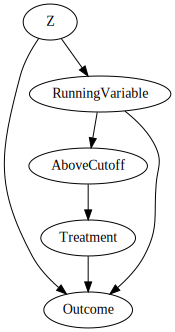

In [2]:

sprinkler = CausalGraphicalModel(
    nodes=["RunningVariable", "AboveCutoff", "Treatment", "Z", "Outcome"],
    edges=[
        ("Z", "RunningVariable"), 
        ("RunningVariable", "AboveCutoff"), 
        ("RunningVariable", "Outcome"),
        ("AboveCutoff", "Treatment"), 
        ("Z", "Outcome"), 
        ("Treatment", "Outcome")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
sprinkler.draw()

In Regression Discontinuity, 2 types of RDD studies are accepted. There are designs in which the probability of treatment goes from 0 to 1 at the cut-off point, (“shap” design), as an example of this design, we can take the reinforcements that can received. And others where the probability increases at the “fuzzy” design cut-off point, a discontinuous jump in the probability of treatment is experienced.

Formally the Sharp design:

$$
D_i =
   \begin{cases} 1
       \text{si} & X_i\geq{c_0}
       \\ 0
       \text{ if } & X_i < c_0
   \end{cases}
$$

and the “Fuzzy” design is

$$
\lim_{X_i\rightarrow{c_0}}
   \Pr\large(D_i=1\mid X_i=c_0\large) \ne
   \lim_{c_0 \leftarrow X_i}
   \Pr\large(D_i=1\mid X_i=c_0\large)
$$


## Pasos

In [3]:
dat = pd.DataFrame({'x': np.random.normal(50, 25, 1000)})
dat.loc[dat.x<0, 'x'] = 0
dat = dat[dat.x<100]
dat['D'] = 0
dat.loc[dat.x>50, 'D'] = 1

dat['y'] = 25 + 40*dat.D + 1.5 * dat.x + np.random.normal(0, 20, dat.shape[0])
dat.head()
dat_0 = dat[dat.D == 0]
dat_1 = dat[dat.D == 1]

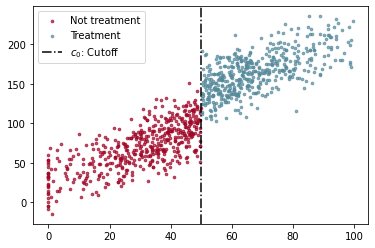

In [4]:



treat_c = "#568A9B"
n_treat = "#A10728"
plt.scatter("x", "y", data = dat_0, color = n_treat, alpha= .7, s = 7, label = "Not treatment")
plt.scatter("x", "y", data = dat_1, color = treat_c, alpha= .7, s = 7, label = "Treatment")
plt.axvline(50, color = "black", linestyle = "-.", label = r"$c_0$: Cutoff")
plt.legend()

In [5]:

def y_hat_lin(da_ta, x = "x", y = "y"):
    yhat = smf.ols(f"{y} ~ {x}", data = da_ta).fit().predict()
    da_ta["yhat"] = yhat
    da_ta.sort_values('yhat', inplace = True)
    return da_ta

data_y0 = y_hat_lin(dat_0)
data_y1 = y_hat_lin(dat_1)

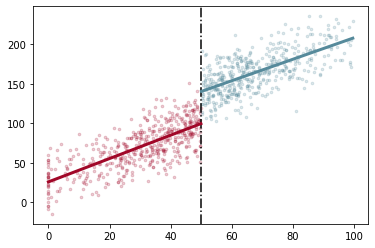

In [6]:
plt.scatter("x", "y", data = dat_0, color = n_treat, alpha= .2, s = 7, label = "Not treatment")
plt.scatter("x", "y", data = dat_1, color = treat_c, alpha= .2, s = 7, label = "Treatment")
plt.axvline(50, color = "black", linestyle = "-.", label = r"$c_0$: Cutoff")

plt.plot("x", "yhat", data = data_y0, color = n_treat, lw = 3)
plt.plot("x", "yhat", data = data_y1, color = treat_c, lw = 3)


In [7]:
eff = min(data_y1.yhat) - max(data_y0.yhat)
eff = round(eff,  2)
print(r"Effect", f"{eff}")

Effect 40.74


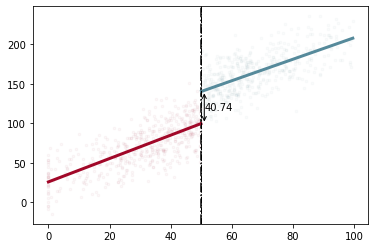

In [8]:

plt.scatter("x", "y", data = dat_0, color = n_treat, alpha= .03, s = 7, label = "Not treatment")
plt.scatter("x", "y", data = dat_1, color = treat_c, alpha= .03, s = 7, label = "Treatment")
plt.axvline(50, color = "black", linestyle = "-.", label = r"$c_0$: Cutoff")

plt.plot("x", "yhat", data = data_y0, color = n_treat, lw = 3)
plt.plot("x", "yhat", data = data_y1, color = treat_c, lw = 3)
plt.axvline(50, color = "black", linestyle = "-.", label = r"$c_0$: Cutoff", lw = 1)
plt.annotate(f"{eff}", xy = (51, eff + 76))
plt.annotate("", xy = (51, max(data_y0.yhat)), xytext = (51, min(data_y1.yhat)), 
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"));

## Kernel

In [9]:
drinking = pd.read_csv("https://github.com/matheusfacure/python-causality-handbook/raw/master/causal-inference-for-the-brave-and-true/data/drinking.csv")

var_rel = ["agecell", "all", "mva", "suicide"]


drinking = drinking[var_rel]

drinking.head()

# cutoff: 21

drinking["agecell"] -= 21
drinking["threshold"]  = (drinking["agecell"] > 0).astype(int)


In [10]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

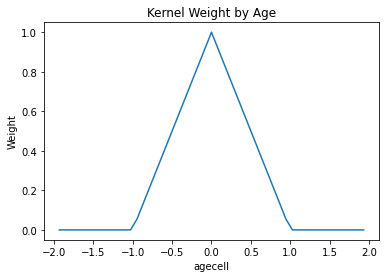

In [11]:
plt.plot(drinking["agecell"], kernel(drinking["agecell"], c=0, h=1))
plt.xlabel("agecell")
plt.ylabel("Weight")
plt.title("Kernel Weight by Age");

In [12]:
drink_0 = drinking[drinking["agecell"] < 0]
drink_1 = drinking[drinking["agecell"] >= 0]

In [18]:
def y_hat_lin(da_ta, x = "x", y = "y"):
    da_ta = da_ta.dropna()

    yhat = smf.wls(f"{y} ~ {x} * threshold", data = da_ta).fit().predict()
    da_ta["yhat"] =  np.array(yhat)
    # return yhat
    da_ta.sort_values(x, inplace = True)
    return da_ta
# [a].append()
# s = y_hat_lin(drink_0, x = "all", y = "agecell")
# s.app

def rdd(data0, data1, x = "agecell", y = "all"):


    globals() ["drink_y0"] = y_hat_lin(data0, x, y)
    globals() ["drink_y1"] = y_hat_lin(data1, x, y)
    l1, l0 = max(drink_y1.yhat), max(drink_y0.yhat)

    plt.plot(x,  "yhat", data = drink_y1)
    plt.plot(x,  "yhat", data = drink_y0)
    plt.scatter(x,  y, data = drink_y1)
    plt.scatter(x,  y, data = drink_y0)
    
    eff = round(100*(((l1 - l0) + l0)/l0 - 1), 2)
    plt.title(f"RDD without kernel:\nEffect {eff} %")


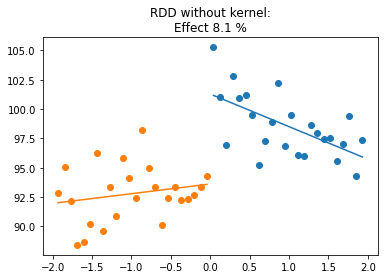

In [19]:
rdd(drink_0, drink_1)


In [15]:
da_ta = drinking.dropna()

weights = kernel(da_ta["agecell"], 0 , h = 1)

yhat = smf.wls(f"all ~ agecell * threshold", data = da_ta, weights = weights).fit().predict()
da_ta["yhat"] =  np.array(yhat)
# # return yhat
da_ta.sort_values("agecell", inplace = True)


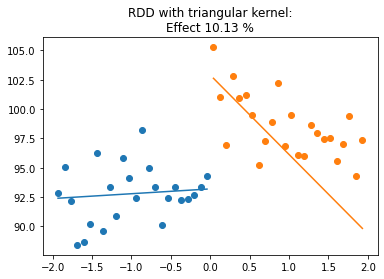

In [17]:
drink_nt = da_ta[da_ta["agecell"] < 0]
drink_t = da_ta[da_ta["agecell"] >= 0]


l1, l0 = max(drink_t.yhat), max(drink_nt.yhat)

eff = round(100*(((l1 - l0) + l0)/l0 - 1), 2)

plt.plot("agecell", "yhat", data = drink_nt)
plt.plot("agecell", "yhat", data = drink_t)
plt.scatter("agecell", "all", data = drink_nt)
plt.scatter("agecell", "all", data = drink_t)
plt.title(f"RDD with triangular kernel:\nEffect {eff} %");